<a href="https://colab.research.google.com/github/1HPz/ChiangMaiRainForecast/blob/main/Predict_Rain_Level_By_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Rain_Volume_in_Chiangmai.csv')
df.head()


Mounted at /content/drive


,ปี-เดือน,ปริมาณน้ำฝน
0,2556-01,0.81
1,2556-02,1.13
2,2556-03,0.55
3,2556-04,0.04
4,2556-05,2.90


# **Check Stationarity**

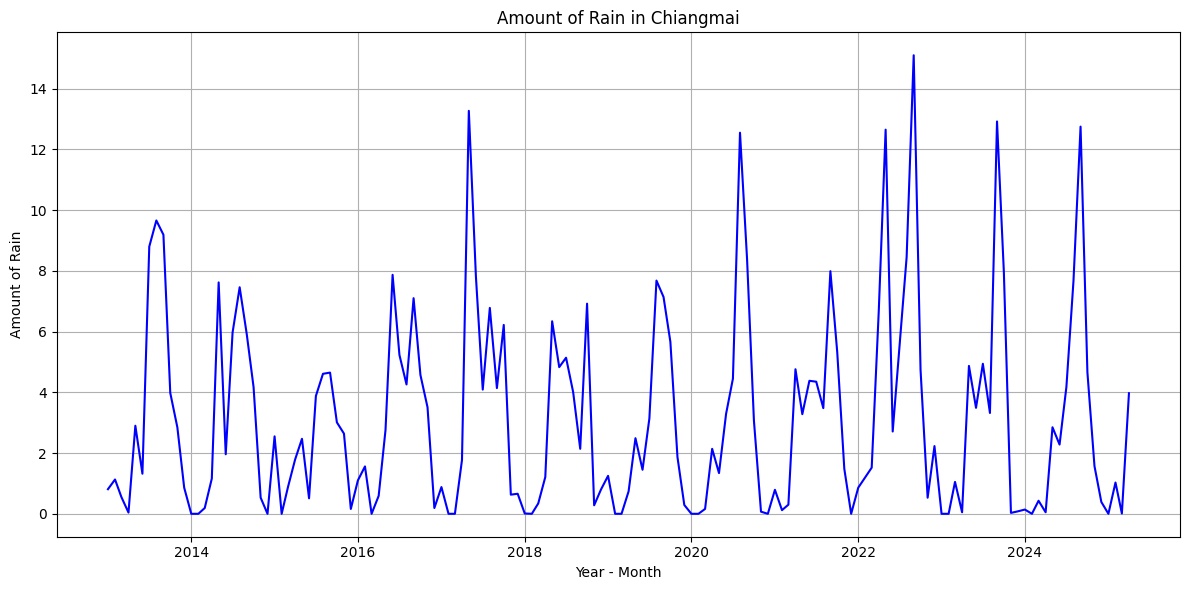

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# แปลงพ.ศ. เป็น ค.ศ.
df['ปี-เดือน'] = df['ปี-เดือน'].apply(lambda x: str(int(x[:4]) - 543) + x[4:])

# แปลงเป็น datetime
df['ปี-เดือน'] = pd.to_datetime(df['ปี-เดือน'], format='%Y-%m', errors='coerce')

# แปลงปริมาณน้ำฝนให้เป็นตัวเลข
df['ปริมาณน้ำฝน'] = pd.to_numeric(df['ปริมาณน้ำฝน'], errors='coerce')

# ลบข้อมูลที่แปลงไม่สำเร็จ
df = df.dropna(subset=['ปี-เดือน', 'ปริมาณน้ำฝน'])

# พล็อตกราฟ
plt.figure(figsize=(12, 6))
plt.plot(df['ปี-เดือน'], df['ปริมาณน้ำฝน'], linestyle='-', color='blue')
plt.xlabel('Year - Month')
plt.ylabel('Amount of Rain')
plt.title('Amount of Rain in Chiangmai')
plt.grid(True)
plt.tight_layout()
plt.show()


**ADF test**

In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['ปริมาณน้ำฝน'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.285277736399023
p-value: 0.17676016591404803


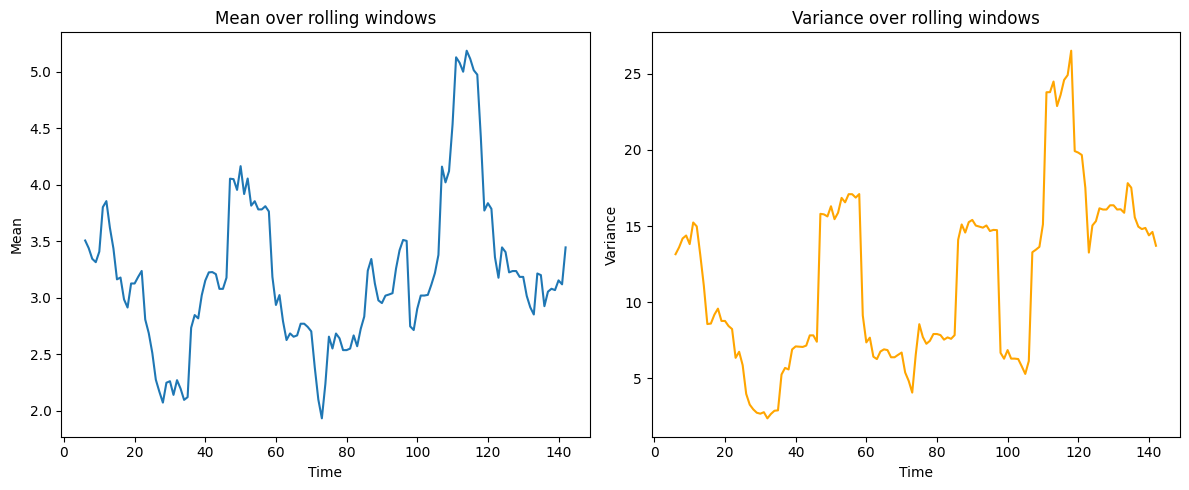

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# สมมติ df.index เป็น datetime และมีคอลัมน์ 'value' หรือเปลี่ยนเป็นชื่อคอลัมน์ของคุณ
series = df['ปริมาณน้ำฝน']

# กำหนดขนาด window เป็นจำนวนเดือน เช่น 12 เดือน (1 ปี)
window_size = 12

# สร้าง lists เก็บค่า mean และ variance ของแต่ละ window
means = []
variances = []
window_centers = []

for start in range(len(series) - window_size + 1):
    window = series.iloc[start:start + window_size]
    means.append(window.mean())
    variances.append(window.var())
    window_centers.append(window.index[window_size // 2])  # เก็บตำแหน่งกลาง window

# แปลงเป็น Series เพื่อ plot
means = pd.Series(means, index=window_centers)
variances = pd.Series(variances, index=window_centers)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(means, marker='')
plt.title('Mean over rolling windows')
plt.xlabel('Time')
plt.ylabel('Mean')

plt.subplot(1,2,2)
plt.plot(variances, marker='', color='orange')
plt.title('Variance over rolling windows')
plt.xlabel('Time')
plt.ylabel('Variance')

plt.tight_layout()
plt.show()


**Transforming to Stationary**

In [5]:
df['y_diff1'] = df['ปริมาณน้ำฝน'] - df['ปริมาณน้ำฝน'].shift(1)  # First order differencing

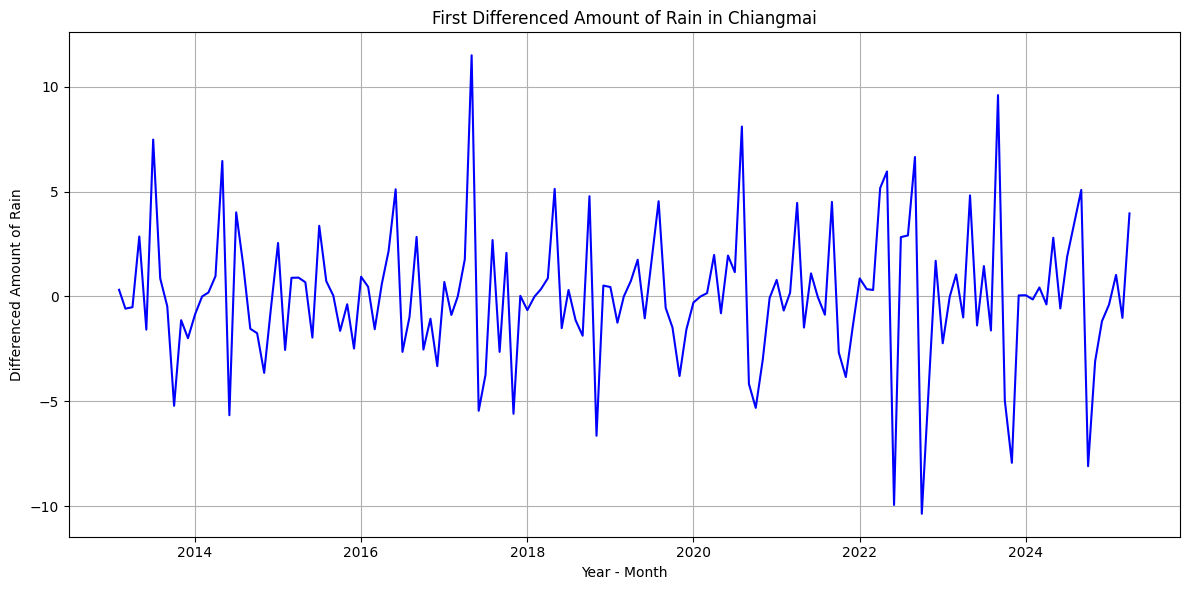

In [6]:
import matplotlib.pyplot as plt
# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(df['ปี-เดือน'], df['y_diff1'], linestyle='-', color='blue')
plt.xlabel('Year - Month')
plt.ylabel('Differenced Amount of Rain')
plt.title('First Differenced Amount of Rain in Chiangmai')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
result_diff = adfuller(df['y_diff1'].dropna())
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])

# ตีความ p-value
alpha = 0.05
if result_diff[1] <= alpha:
    print("p-value <= alpha (", alpha, "): Reject the null hypothesis (H0). The data is stationary.")
else:
    print("p-value > alpha (", alpha, "): Fail to reject the null hypothesis (H0). The data is non-stationary.")

ADF Statistic (Differenced): -12.088999431240106
p-value (Differenced): 2.1442534580916813e-22
p-value <= alpha ( 0.05 ): Reject the null hypothesis (H0). The data is stationary.


# **SARIMA Model**

**Analyze ACF and PACF to Choose Lag Parameters**

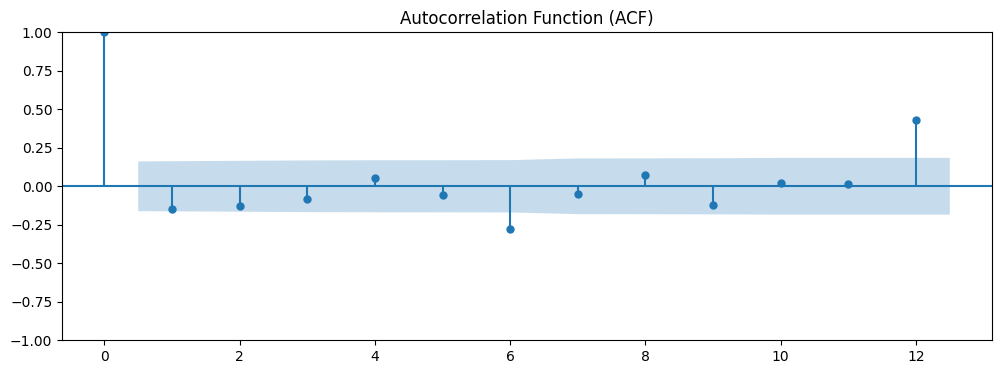

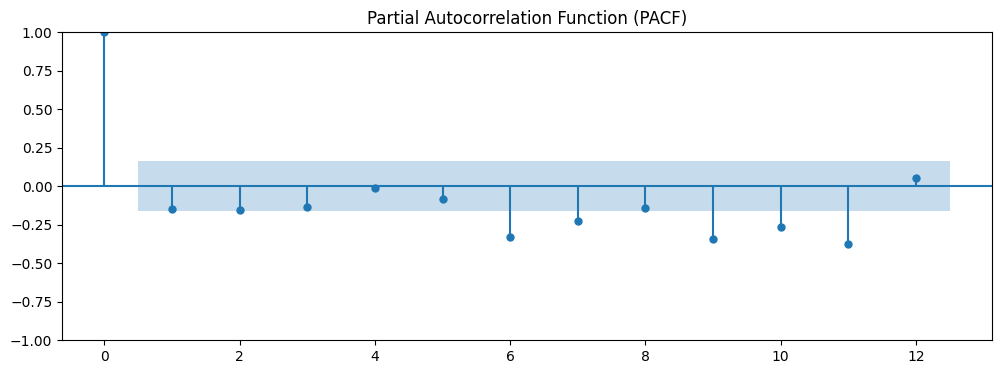

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary_series = df['y_diff1'].dropna()

# Plot ACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(stationary_series, ax=ax, lags=12) # You can adjust the number of lags
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(stationary_series, ax=ax, lags=12) # You can adjust the number of lags
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**Test-Train spilt**

In [14]:
# train-test spilt
train = df.loc[:'2023-12']
test = df.loc['2024-01':'2025-03']

(118, 3)
(30, 3)


KeyError: 'None of [RangeIndex(start=0, stop=118, step=1)] are in the [index]'

**Deploy SARIMA Model**

In [11]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Check what is the best parameter for SARIMA
# ตั้งค่าให้ไม่แสดง warning เวลาฟิตโมเดล
warnings.filterwarnings("ignore")

# พารามิเตอร์ตามที่กำหนด
p_values = [6, 7, 9, 10, 11]
d = 1
q_values = [6, 12]
P = 0
D = 1
Q = 1
s = 12

# สำหรับเก็บผลลัพธ์
results = []
best_aic = float("inf")
best_params = None

# วนลูปทุก combination ของ (p, q)
for p, q in itertools.product(p_values, q_values):
    try:
        model = SARIMAX(
            train['y_diff1'].dropna(),
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        aic = model_fit.aic

        results.append(((p, d, q), (P, D, Q, s), aic))

        if aic < best_aic:
            best_aic = aic
            best_params = ((p, d, q), (P, D, Q, s))

        print(f"Tested ARIMA{(p, d, q)} x {(P, D, Q, s)} - AIC: {aic:.2f}")

    except Exception as e:
        print(f"Model failed for ARIMA{(p, d, q)} - {e}")

# แสดงพารามิเตอร์ที่ดีที่สุด
print("\nBest model parameters:")
print(f"Order: {best_params[0]}, Seasonal Order: {best_params[1]}, AIC: {best_aic:.2f}")


Tested ARIMA(6, 1, 6) x (0, 1, 1, 12) - AIC: 28.00
Model failed for ARIMA(6, 1, 12) - Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Tested ARIMA(7, 1, 6) x (0, 1, 1, 12) - AIC: 30.00
Model failed for ARIMA(7, 1, 12) - Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Tested ARIMA(9, 1, 6) x (0, 1, 1, 12) - AIC: 34.00
Model failed for ARIMA(9, 1, 12) - Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Tested ARIMA(10, 1, 6) x (0, 1, 1, 12) - AIC: 36.00
Model failed for ARIMA(10, 1, 12) - Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Tested ARIMA(11, 1, 6) x (0, 1, 1, 12) - AIC: 38.00
Model failed for ARIMA(11, 1, 12) - Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and n

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_x = SARIMAX(
    train['y_diff1'].dropna(),
    order=(6, 1, 6),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_x_fit = model_x.fit(disp=False)
print(model_x_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              y_diff1   No. Observations:                   20
Model:             SARIMAX(6, 1, 6)x(0, 1, [1], 12)   Log Likelihood                   0.000
Date:                              Fri, 18 Jul 2025   AIC                             28.000
Time:                                      10:21:13   BIC                                nan
Sample:                                           0   HQIC                               nan
                                               - 20                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ar.L2              

RMSE: 11.3912


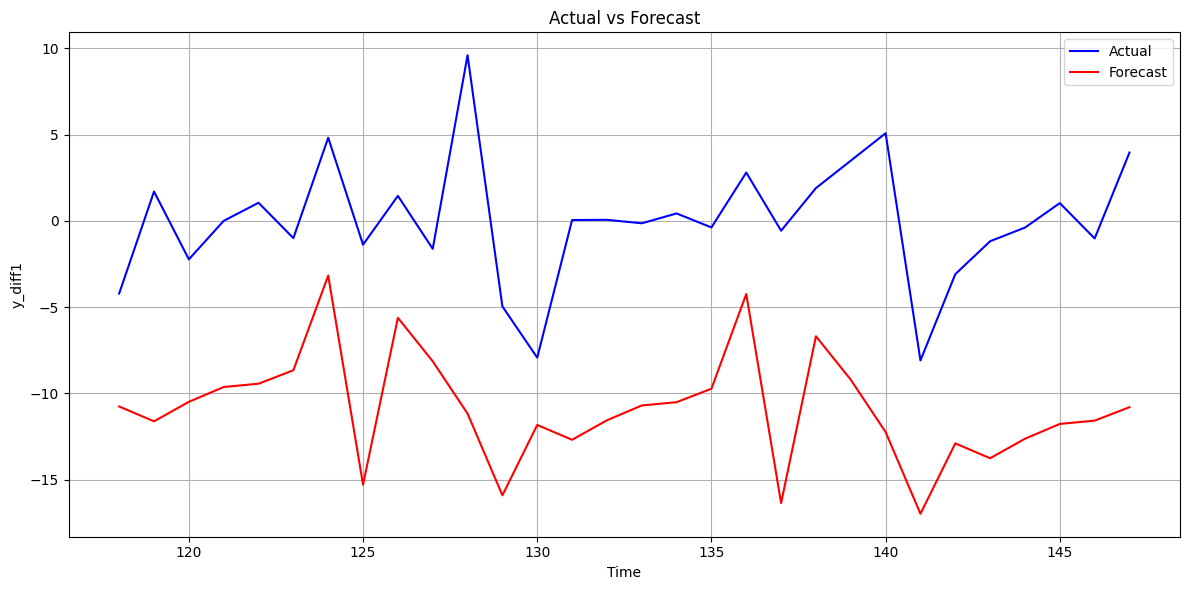

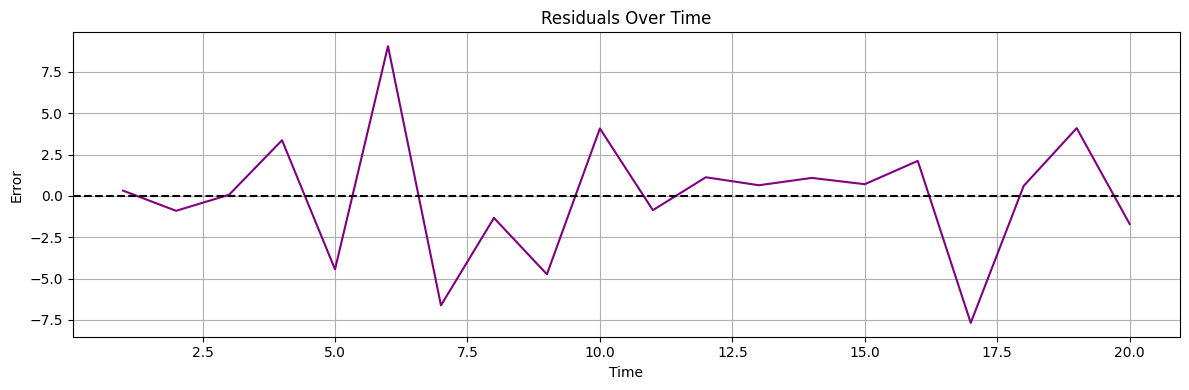

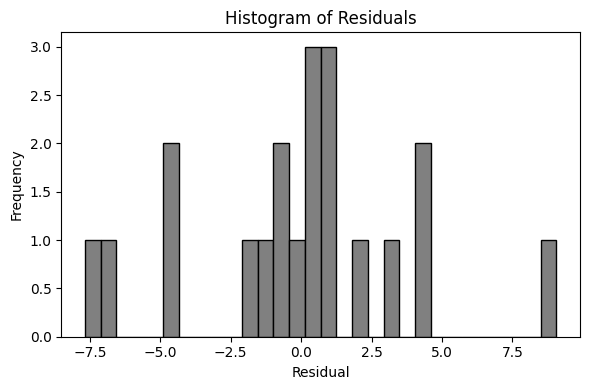

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# ===== 🔹 พยากรณ์ในช่วง test =====
start = len(train['y_diff1'].dropna())
end = start + len(test) - 1

forecast = model_x_fit.predict(start=start, end=end, dynamic=False)

# ===== 🔹 คำนวณ RMSE =====
rmse = np.sqrt(mean_squared_error(test['y_diff1'], forecast))
print(f"RMSE: {rmse:.4f}")

# ===== 🔹 พล็อต Actual vs Forecast =====
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['y_diff1'], label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Actual vs Forecast')
plt.xlabel('Time')
plt.ylabel('y_diff1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== 🔹 พล็อต Residuals =====
residuals = model_x_fit.resid

plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== 🔹 Histogram ของ Residuals =====
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='gray', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
